In [77]:
data_dir="/kaggle/input/puma-balen-adidas-nike"

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob # returns all file paths that match a specific pattern
import cv2 
import imghdr #identifies different image file formats
import warnings
warnings.filterwarnings("ignore")

In [79]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [80]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #loads an image from the specified file
            tip = imghdr.what(image_path) #tests the image data contained in the file
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile


In [81]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 2271 files belonging to 4 classes.


In [82]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

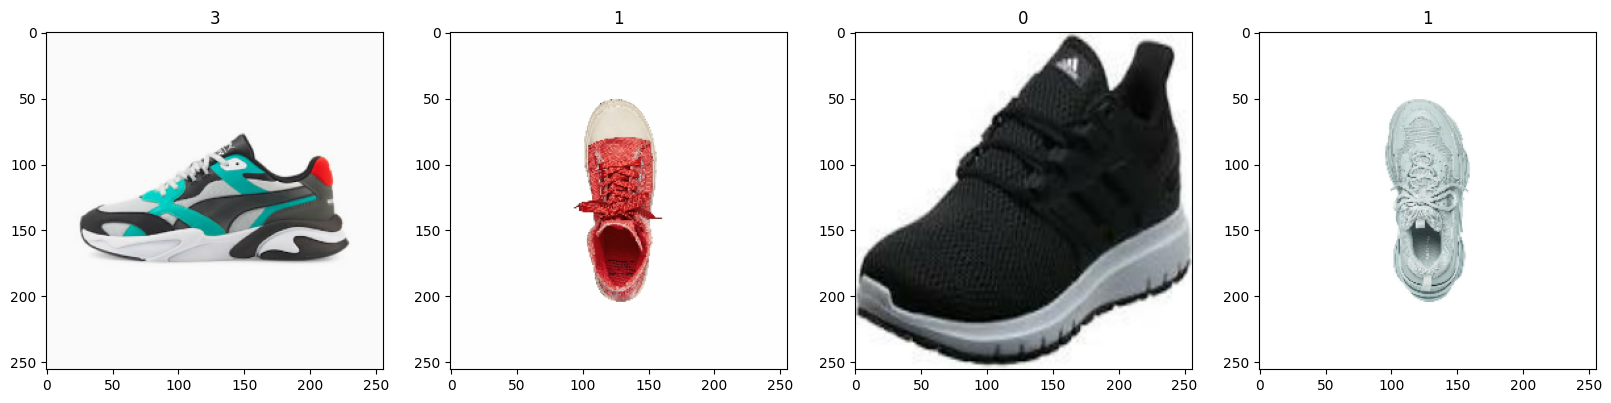

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [84]:
batch_size = 32
img_height = 224
img_width = 224

In [85]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2271 files belonging to 4 classes.
Using 1817 files for training.


In [86]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2271 files belonging to 4 classes.
Using 454 files for validation.


In [87]:
class_names = train_ds.class_names
print(class_names)

['Adidas', 'Balenciaga', 'Nike', 'Puma']


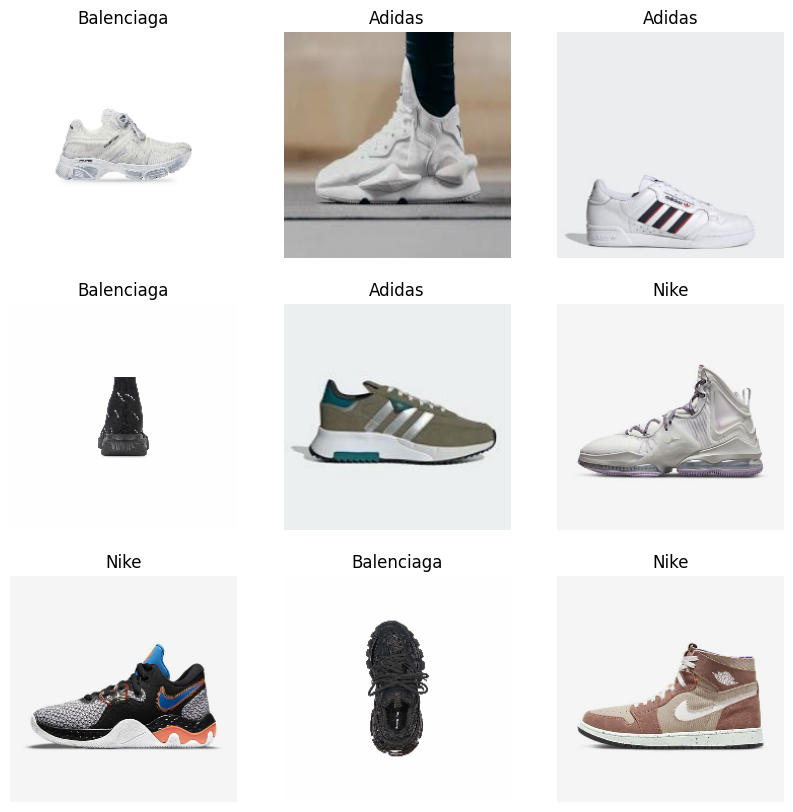

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [89]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [90]:
AUTOTUNE = tf.data.AUTOTUNE #tunes the value dynamically at runtime.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [91]:
normalization_layer = layers.Rescaling(1./255)

In [92]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [93]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)      

In [96]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
57/57 [==============================] - 6s 71ms/step - loss: 1.9569 - accuracy: 0.7837 - val_loss: 2.9608 - val_accuracy: 0.8348
Epoch 2/10
57/57 [==============================] - 2s 31ms/step - loss: 2.0589 - accuracy: 0.8960 - val_loss: 0.6482 - val_accuracy: 0.8943
Epoch 3/10
57/57 [==============================] - 2s 31ms/step - loss: 2.0859 - accuracy: 0.8740 - val_loss: 0.8028 - val_accuracy: 0.8656
Epoch 4/10
57/57 [==============================] - 2s 32ms/step - loss: 1.1835 - accuracy: 0.9081 - val_loss: 0.8318 - val_accuracy: 0.8899
Epoch 5/10
57/57 [==============================] - 2s 34ms/step - loss: 1.0724 - accuracy: 0.9130 - val_loss: 0.8536 - val_accuracy: 0.9009
Epoch 6/10
57/57 [==============================] - 2s 32ms/step - loss: 1.0916 - accuracy: 0.9290 - val_loss: 1.3154 - val_accuracy: 0.8260
Epoch 7/10
57/57 [==============================] - 2s 31ms/step - loss: 0.5085 - accuracy: 0.9081 - val_loss: 0.5189 - val_accuracy: 0.9141
Epoch 8/10
57

In [222]:
def plot_decision_percentage(score):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots() 
    y=['Adidas','Balenciaga' ,'Nike', 'Puma']
    y_axis = [0,0.5,1,1.5]
    # getting values against each value of y
    plt.barh(y_axis, score,0.5)
    plt.yticks(y_axis,y)
    # setting label of y-axis
    plt.ylabel("brand")
    # setting label of x-axis
    plt.xlabel("percentage") 
    for bar, percen in zip(ax.patches, score.numpy().astype(np.float32)*100):
        if percen/200>0.4:
            ax.text(percen/200, bar.get_y()+bar.get_height()/2, str(percen)+"%", color = 'white', ha = 'center', va = 'center') 
    plt.title("result")
    plt.show()

1/1 [==============================] - 0s 19ms/step
(4,)
tf.Tensor(1.0, shape=(), dtype=float32)


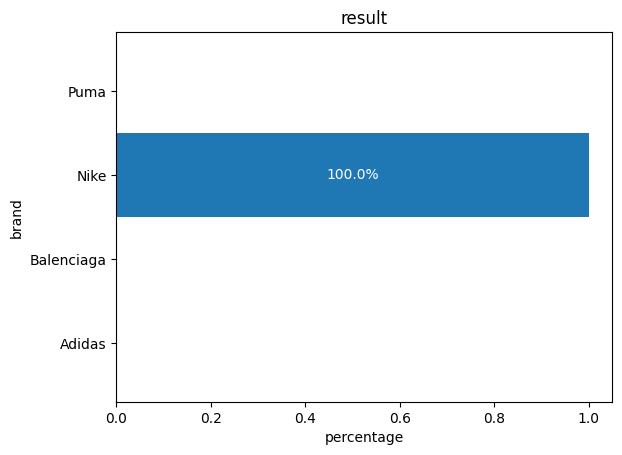

This image most likely belongs to Nike.


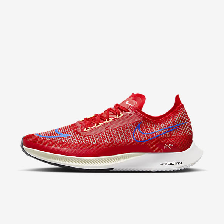

In [223]:
findshoe_url = "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/3291fa27-8fc2-4ca5-9662-8192083045e1/streakfly-road-racing-shoes-V17qZm.png"
findss_path = tf.keras.utils.get_file('streakfly-road-racing-shoes-V17qZm', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score.shape)
print(score[2])
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 20ms/step


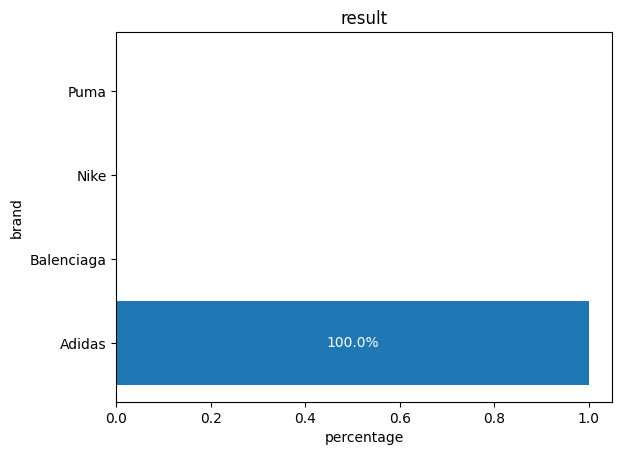

This image most likely belongs to Adidas.


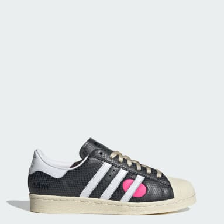

In [224]:
findshoe_url = "https://assets.adidas.com/images/w_383,h_383,f_auto,q_auto,fl_lossy,c_fill,g_auto/bdb1cfa75d5c4af6b42f523e4bde582d_9366/superstar-82-trainers.jpg"
findss_path = tf.keras.utils.get_file('superstar-82-trainers', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 18ms/step


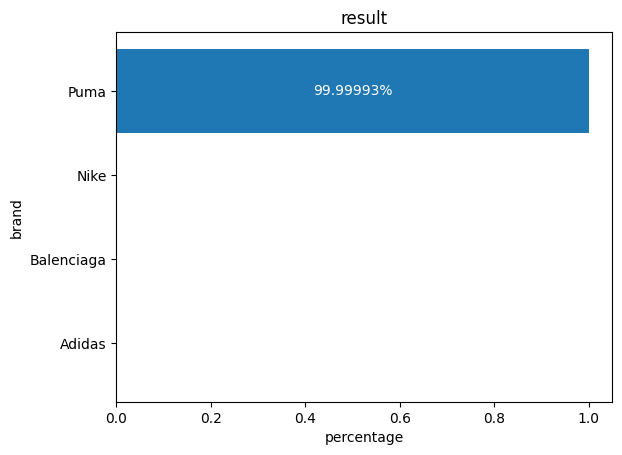

This image most likely belongs to Puma.


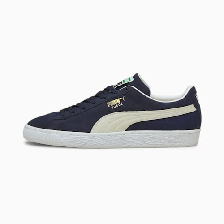

In [225]:
findshoe_url = "https://images.puma.com/image/upload/f_auto,q_auto,b_rgb:fafafa,w_500,h_500/global/374915/04/sv01/fnd/PNA/fmt/png/Suede-Classic-XXI-Sneakers"
findss_path = tf.keras.utils.get_file('Suede-Classic-XXI-Sneakers', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 18ms/step
tf.Tensor([2.5634345e-02 9.7154397e-01 6.9262178e-06 2.8146799e-03], shape=(4,), dtype=float32)
tf.Tensor(0.48577198, shape=(), dtype=float32)


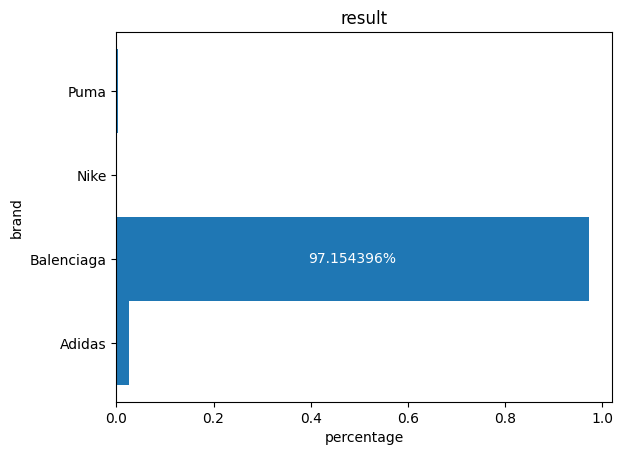

This image most likely belongs to Balenciaga.


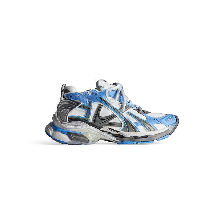

In [226]:
findshoe_url = "https://balenciaga.dam.kering.com/m/5700213e47806d0b/Small-772774W3RNY4912_X.jpg?v=6"
findss_path = tf.keras.utils.get_file('Small-772774W3RNY4912_X.jpg', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(score[1]*100/200)
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

Text(0.5, 1.0, 'Training and Validation Accuracy')

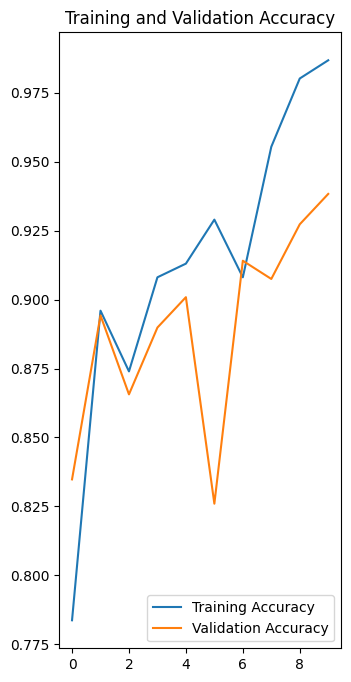

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


In [102]:
model.save("/kaggle/working/my_model.keras")

In [112]:
model.save("/kaggle/working/my_model.h5")

In [115]:
rm file.zip

In [116]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'model.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [117]:
zip_dir()

/kaggle/working/model.zip

In [58]:
#importing VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input 

In [59]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)

# create a model object
model2 = Model(inputs=vgg.input, outputs=prediction)

58889256/58889256 [==============================] - 2s 0us/step


In [60]:
model2.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
  
)
# view the structure of the model
model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [61]:
epochs=10
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
57/57 [==============================] - 10s 123ms/step - loss: 12.8397 - accuracy: 0.8938 - val_loss: 15078.2256 - val_accuracy: 0.9163
Epoch 2/10
57/57 [==============================] - 5s 82ms/step - loss: 2.2063 - accuracy: 0.9692 - val_loss: 13833.3711 - val_accuracy: 0.9251
Epoch 3/10
57/57 [==============================] - 5s 81ms/step - loss: 0.5351 - accuracy: 0.9862 - val_loss: 17832.1797 - val_accuracy: 0.9405
Epoch 4/10
57/57 [==============================] - 5s 81ms/step - loss: 0.0380 - accuracy: 0.9961 - val_loss: 15351.8877 - val_accuracy: 0.9207
Epoch 5/10
57/57 [==============================] - 5s 81ms/step - loss: 0.2932 - accuracy: 0.9923 - val_loss: 18040.8223 - val_accuracy: 0.9405
Epoch 6/10
57/57 [==============================] - 5s 81ms/step - loss: 0.0624 - accuracy: 0.9972 - val_loss: 18009.6094 - val_accuracy: 0.9383
Epoch 7/10
57/57 [==============================] - 5s 82ms/step - loss: 1.1318 - accuracy: 0.9879 - val_loss: 23906.7832 - val

Text(0.5, 1.0, 'Training and Validation Accuracy')

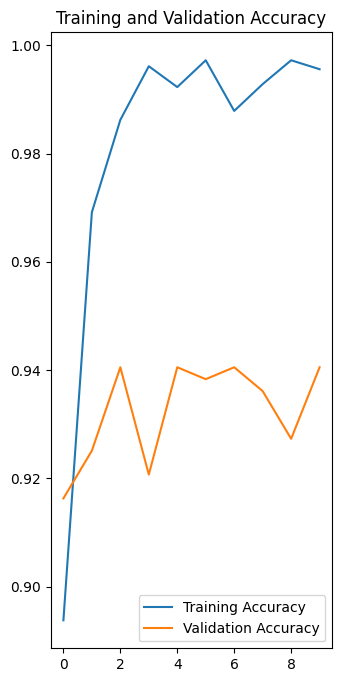

In [62]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']


loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


In [64]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

# k train layer
for layer in base_model.layers:
    layer.trainable = False

model3 = Sequential()

model3.add(base_model)

model3.add(Flatten())

model3.add(Dense(units=6, activation="softmax"))

In [70]:
# checkpoint = ModelCheckpoint("/content/drive/MyDrive/Mobilenet_ECG_classification.h5",
#                              monitor="val_loss",
#                              mode="min",
#                              save_best_only = True,
#                              verbose=1)
model3.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [71]:
epochs = 10

history=model3.fit( train_ds, steps_per_epoch = 30, verbose=1, epochs = epochs, validation_data = val_ds)

Epoch 1/10
30/30 [==============================] - 5s 76ms/step - loss: 1.5716 - accuracy: 0.8156 - val_loss: 1.3551 - val_accuracy: 0.8326
Epoch 2/10
30/30 [==============================] - 1s 50ms/step - loss: 0.8488 - accuracy: 0.9067 - val_loss: 0.8433 - val_accuracy: 0.9207


1/1 [==============================] - 0s 462ms/step
This image most likely belongs to Puma.


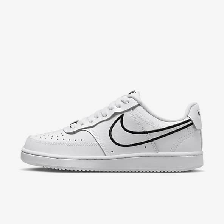

In [76]:
findshoe_url = "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/eb7cf085-652d-466a-bf87-3ab634b82e22/court-vision-low-shoes-fJzKh1.png"
findss_path = tf.keras.utils.get_file('court-vision-low-shoes-fJzKh1', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img